In [83]:
!python -V

Python 3.10.17


In [84]:
import pandas as pd

In [85]:
import pickle

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

In [87]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [88]:
# Configuration MLflow correcte pour devcontainer
import mlflow

# Utilise le fichier mlflow.db à la racine du projet
mlflow.set_tracking_uri("sqlite:////workspaces/mlops-zoomcamp/mlflow.db")
mlflow.set_experiment("nyc_taxi_experiment")

print("Tracking URI:", mlflow.get_tracking_uri())
print("Expérience courante:", mlflow.get_experiment_by_name("nyc_taxi_experiment"))

INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/05/20 18:58:37 INFO mlflow.tracking.fluent: Experiment with name 'nyc_taxi_experiment' does not exist. Creating a new experiment.
2025/05/20 18:58:37 INFO mlflow.tracking.fluent: Experiment with name 'nyc_taxi_experiment' does not exist. Creating a new experiment.


Tracking URI: sqlite:////workspaces/mlops-zoomcamp/mlflow.db
Expérience courante: <Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/notebooks/mlruns/1', creation_time=1747767517063, experiment_id='1', last_update_time=1747767517063, lifecycle_stage='active', name='nyc_taxi_experiment', tags={}>


In [89]:
df = pd.read_parquet('/workspaces/mlops-zoomcamp/02-experiment-tracking/data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [90]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.827368941909368

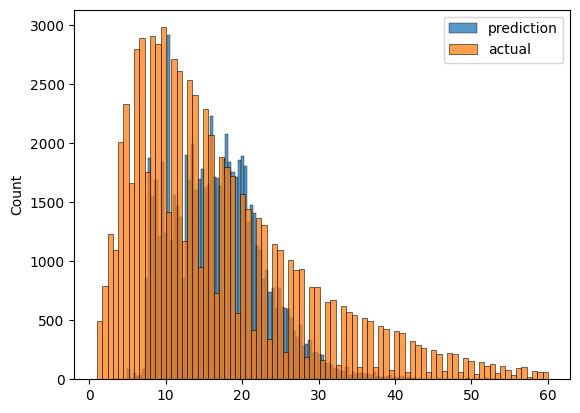

In [91]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

In [92]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [93]:
df_train = read_dataframe('/workspaces/mlops-zoomcamp/02-experiment-tracking/data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('/workspaces/mlops-zoomcamp/02-experiment-tracking/data/green_tripdata_2021-02.parquet')

In [94]:
len(df_train), len(df_val)

(73908, 61921)

In [95]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [96]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [97]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [98]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715203628836

In [99]:
import os

# Crée le dossier 'models' s'il n'existe pas déjà
os.makedirs('models', exist_ok=True)

with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [100]:
with mlflow.start_run():

    mlflow.set_tag("developer", "arnaud")

    mlflow.log_param("train-data-path", "/workspaces/mlops-zoomcamp/02-experiment-tracking/data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "/workspaces/mlops-zoomcamp/02-experiment-tracking/data/green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)
